In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
#import celltypist
#import scvi
import scvelo as scv
#from celltypist import models
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import rc_context

sc.set_figure_params(dpi=100, color_map = 'viridis_r', transparent=False, frameon=False)
sc.settings.verbosity = 1
sc.logging.print_header()

version = '2023-05-16'

sc.settings.figdir = './scanpy/{}/graph'.format(version)
sc.settings.cachedir = './scanpy/{}/cache'.format(version)
%config InlineBackend.figure_format = 'retina'

# matplot 输出的图片为illustrator可编辑的字体
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.0 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.7


# Data

In [2]:
adata_MC = sc.read('./write/MC_leiden.h5ad')
adata_MC.uns['log1p']["base"] = None
adata_MC

AnnData object with n_obs × n_vars = 33577 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels_NC2022', 'majority_voting_NC2022', 'predicted_labels_builtin', 'majority_voting_builtin', 'leiden', 'Major_cluster', 'Sample', 'Minor_cluster', 'Major_category'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Major_category_colors', 'Major_cluster_colors', 'Minor_cluster_colors', 'Phenotype_colors', 'donor_id_colors', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_NC2022_colors', 'majority_voting_builtin_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'matrix', 'spli

In [3]:
adata_MC_T = adata_MC[adata_MC.obs['Major_category'] == 'T']
adata_MC_T

View of AnnData object with n_obs × n_vars = 9607 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels_NC2022', 'majority_voting_NC2022', 'predicted_labels_builtin', 'majority_voting_builtin', 'leiden', 'Major_cluster', 'Sample', 'Minor_cluster', 'Major_category'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Major_category_colors', 'Major_cluster_colors', 'Phenotype_colors', 'donor_id_colors', 'leiden', 'log1p', 'majority_voting_NC2022_colors', 'majority_voting_builtin_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'matrix', 'spliced', 'unspliced'
    obsp: 'conne

# T markers

meta NOT subset; don't know how to subset; dropped


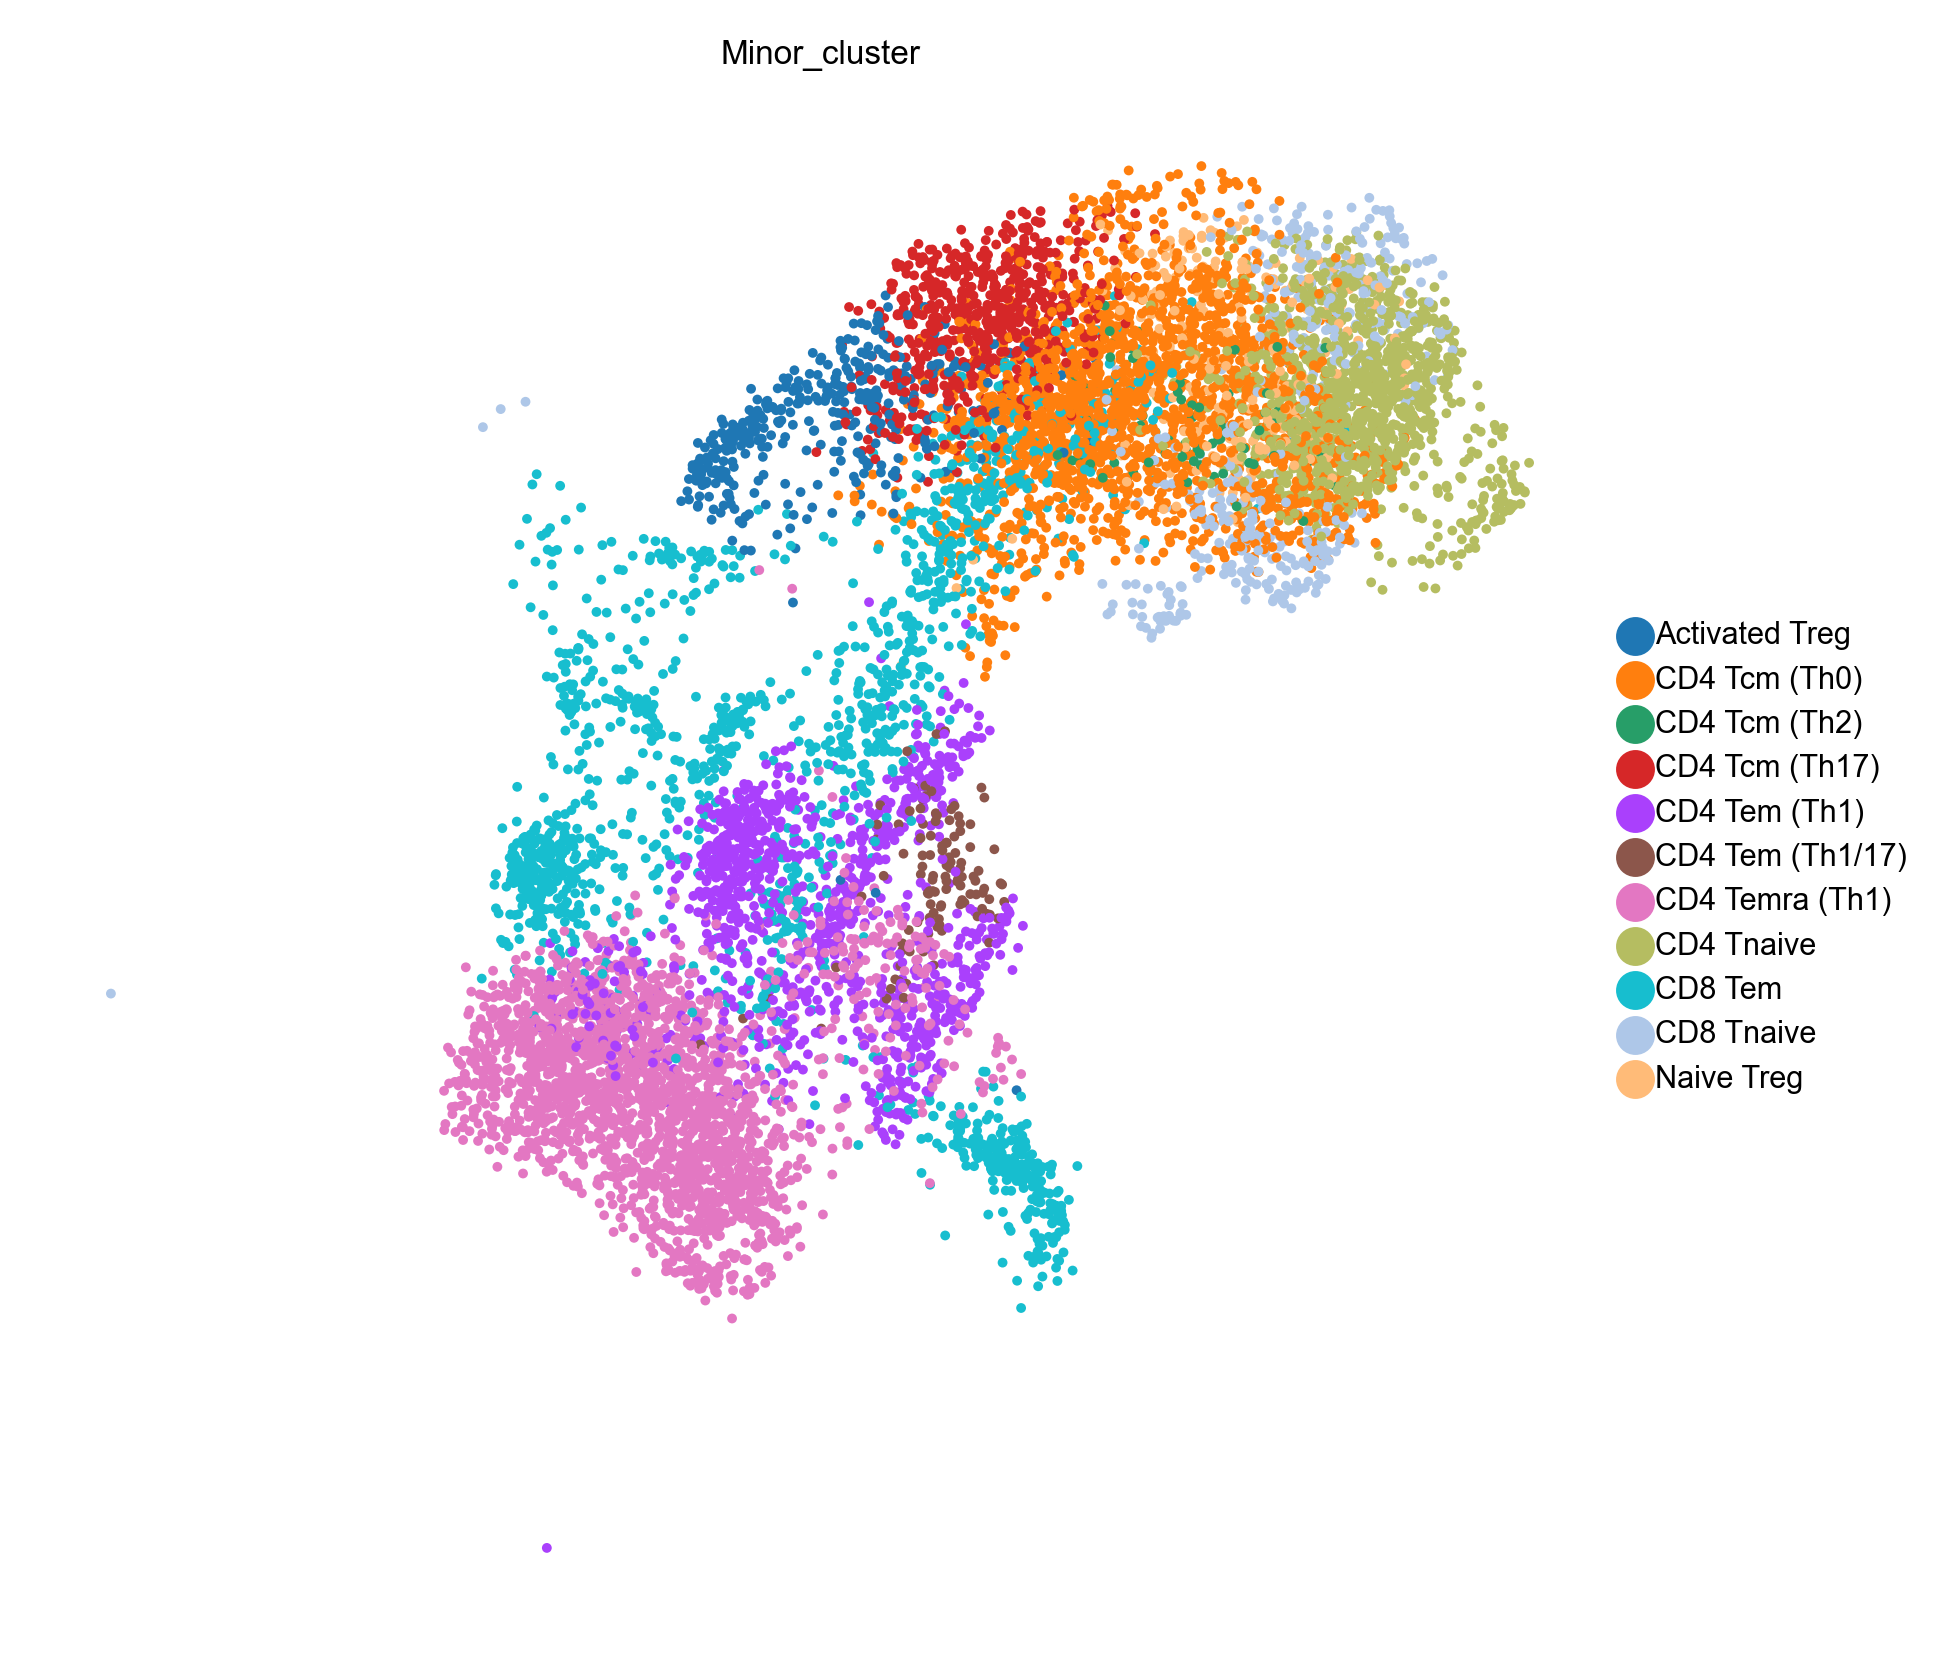

In [8]:
sc.set_figure_params(dpi=200, figsize= [5, 5], fontsize=6, transparent=False, frameon=False) #figsize= [8, 2], fontsize=6, viridis_r

sc.pl.umap(adata_MC_T, color=['Minor_cluster'],  save='T Minor_cluster' , vmin= 2, color_map= 'viridis',) #palette= 'tab20',legend_loc = 'on data'

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


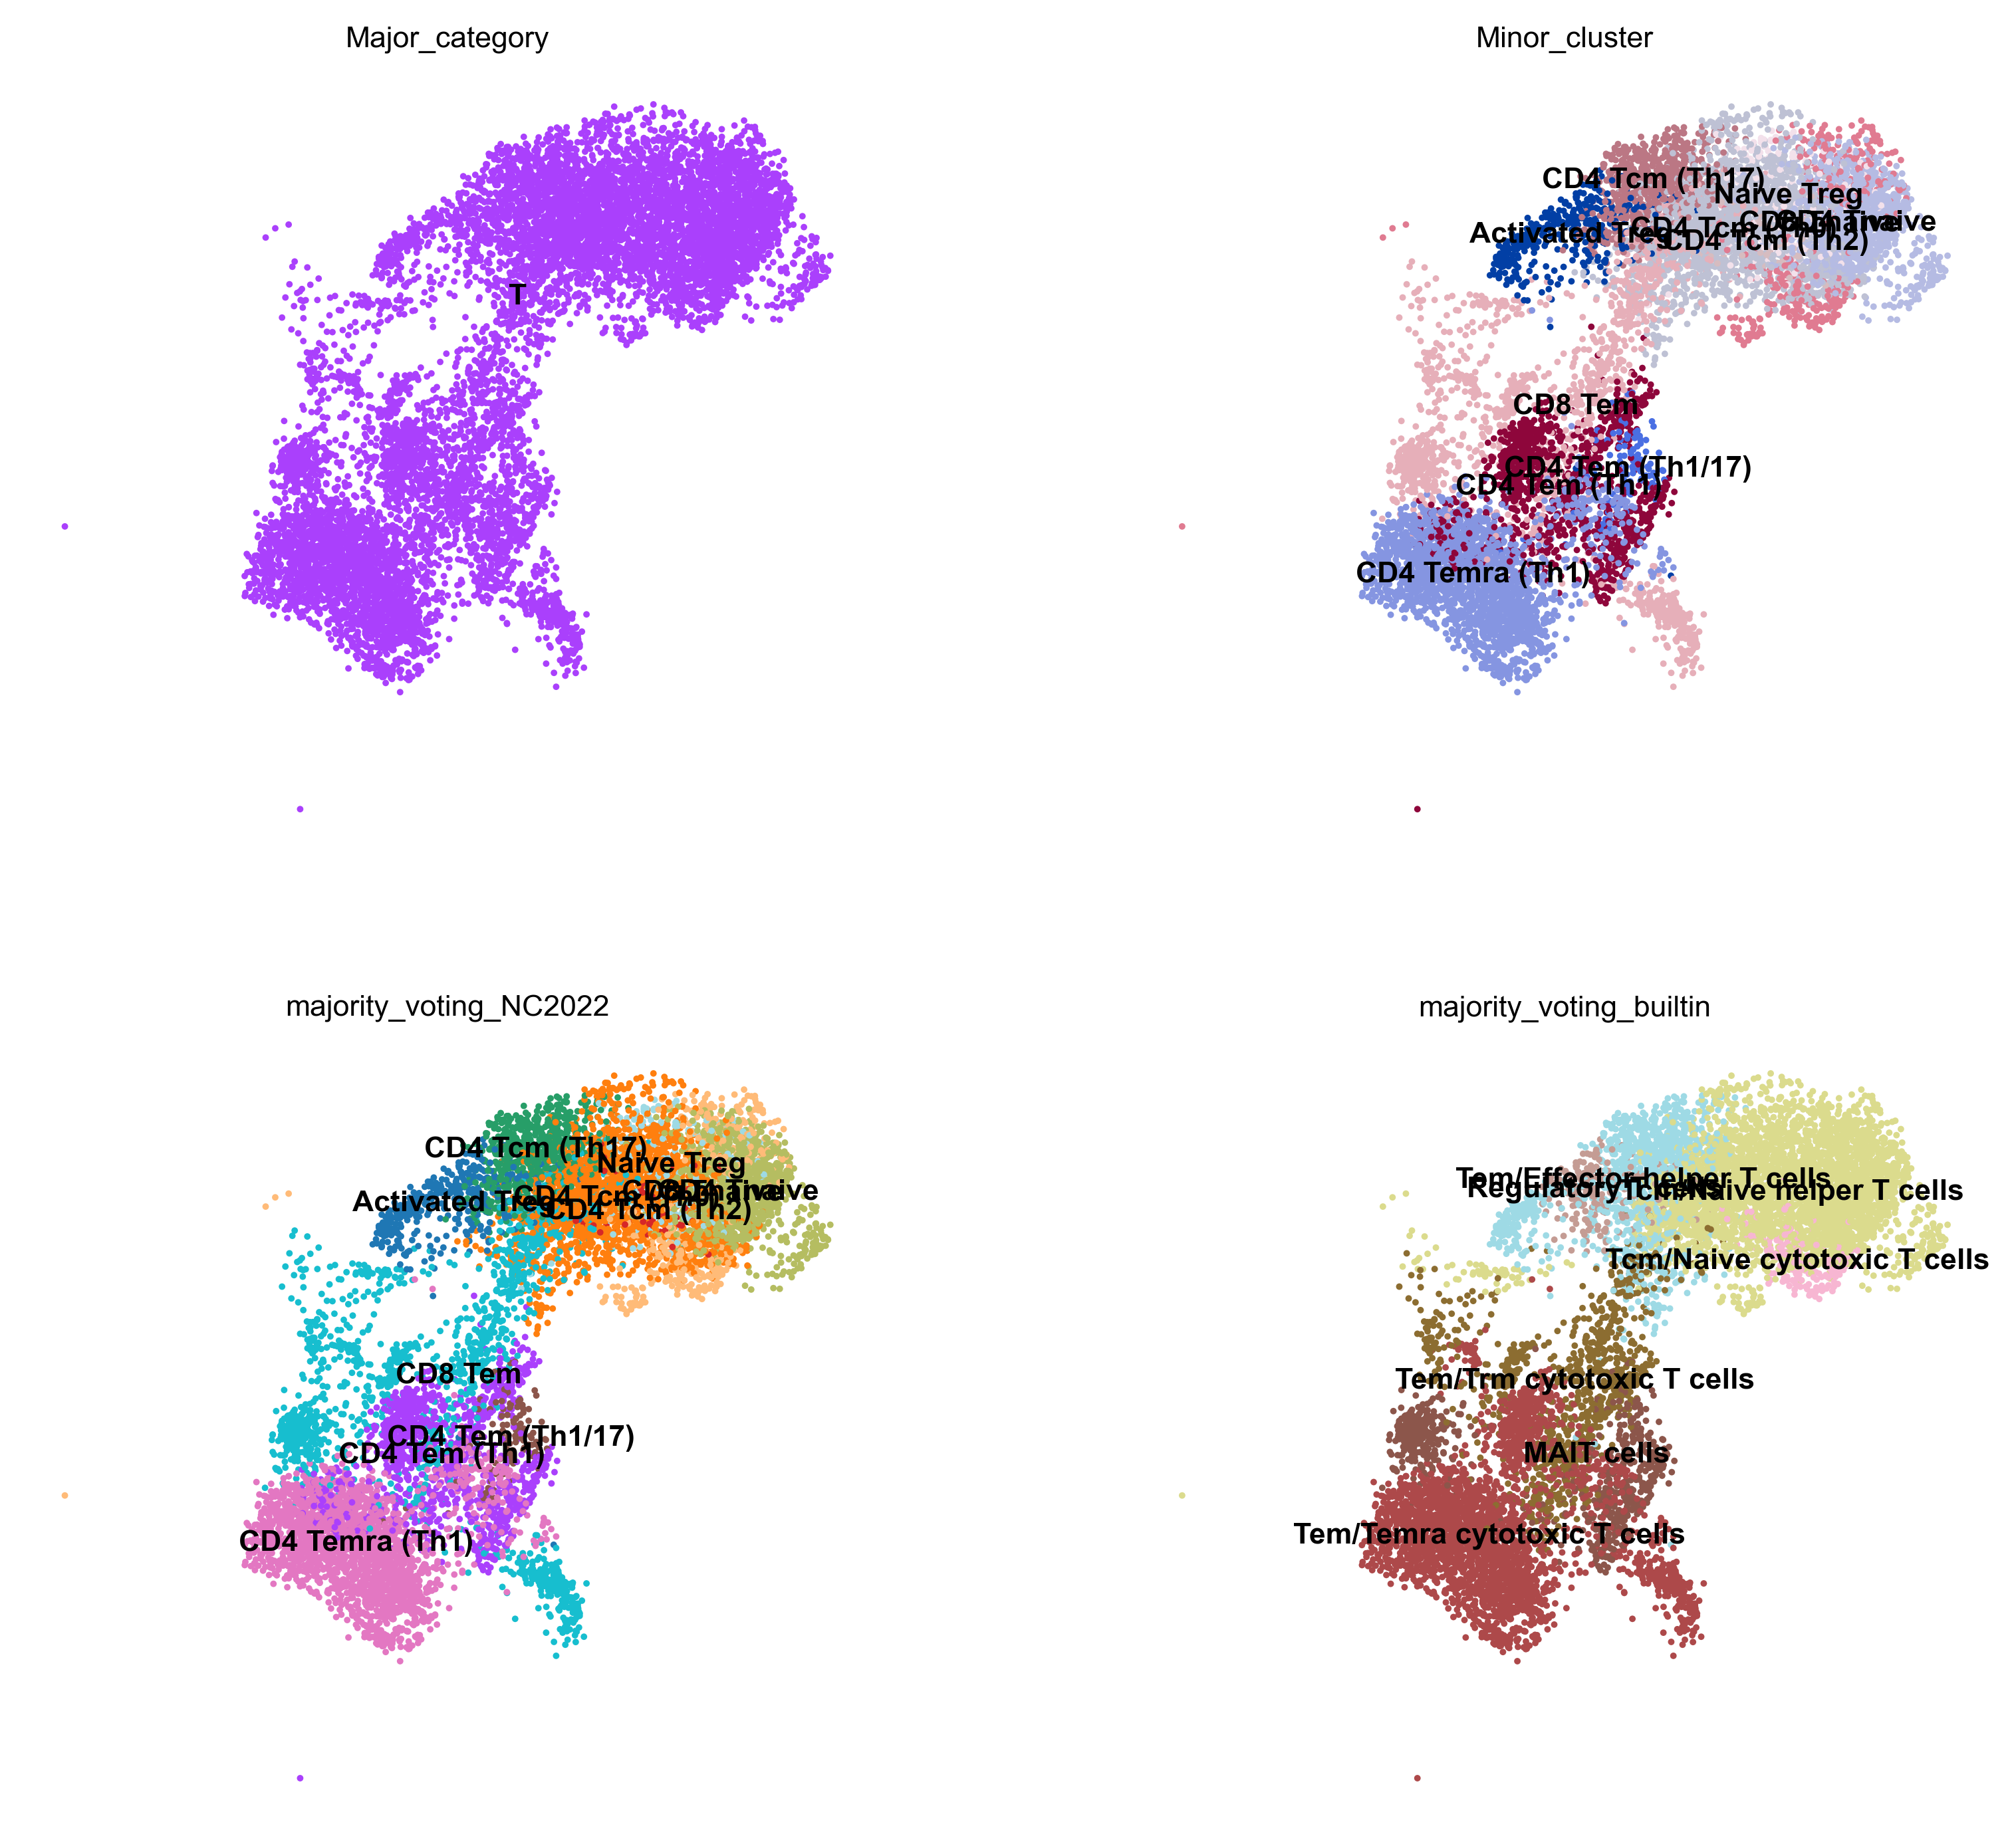

In [5]:
sc.set_figure_params(dpi=200, color_map = 'viridis_r', fontsize=8, transparent=True, frameon=False)

sc.pl.umap(adata_MC_T, color=['Major_category', 'Minor_cluster','majority_voting_NC2022', 'majority_voting_builtin'], legend_loc = 'on data', save='umap_leiden', ncols=2) 

categories: Activated Treg, CD4 Tcm (Th0), CD4 Tcm (Th2), etc.
var_group_labels: CD8 Tem, CD4 Tnaive, CD4 Tcm (Th0), etc.


meta NOT subset; don't know how to subset; dropped


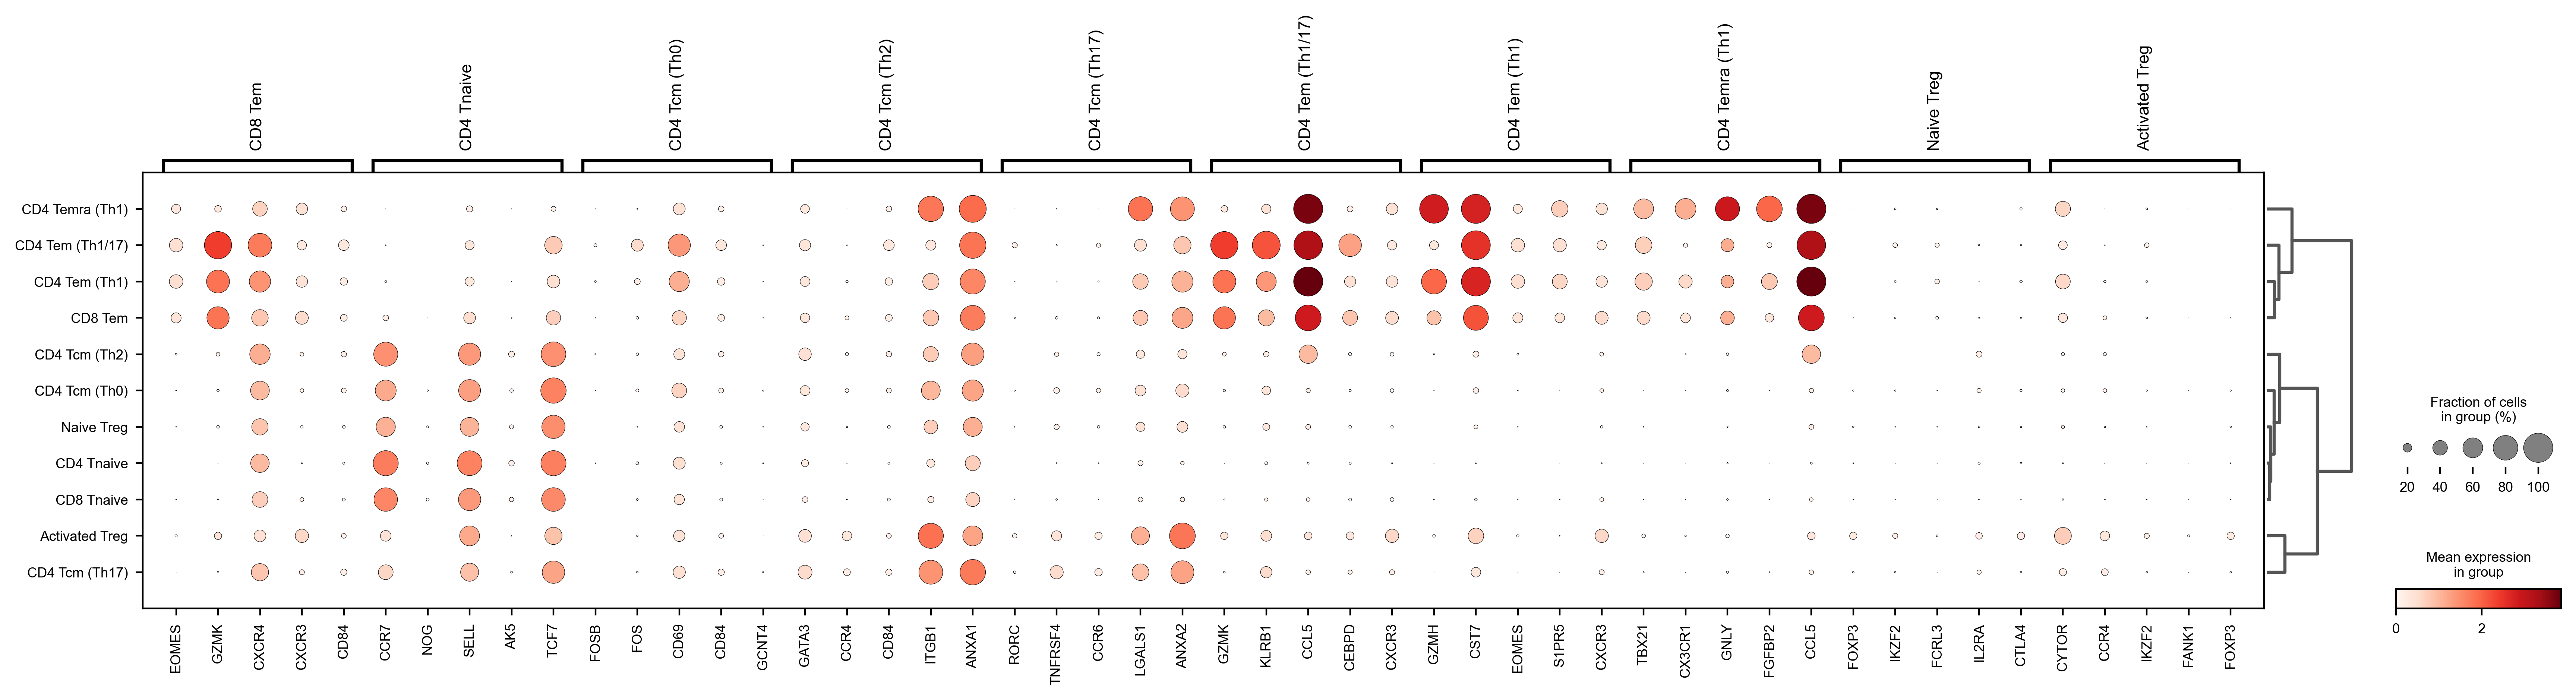

In [6]:
# T NC2022 version

marker_genes_dict = {

    #'CD8 Tnaive':	['CD8B', 'KLRK1', 'S100B', 'LRRN3', 'PASK'],
    'CD8 Tem':	['EOMES', 'GZMK', 'CXCR4', 'CXCR3', 'CD84'],
    #'CD8 Trm':	['RGS1', 'CCL4L2', 'CXCR6', 'CCL3L1', 'ITGA1'],
    #'CD8 Temra':	['FCGR3A', 'NKG7', 'GNLY', 'KLRD1', 'CCL4'],
    #'NKT cells': ['NKG7', 'GNLY', 'CD8A', 'NKG7', 'GNLY', 'IL32'],
    'CD4 Tnaive':	['CCR7',	'NOG',	'SELL',	'AK5',	'TCF7'],
    'CD4 Tcm (Th0)':	['FOSB',	'FOS',	'CD69',	'CD84',	'GCNT4'],
    'CD4 Tcm (Th2)':	['GATA3',	'CCR4',	'CD84',	'ITGB1',	'ANXA1'],
    #'CD4 Tcm (Tfh)':	['CXCR5',	'MAF',	'TIGIT',	'IKZF3',	'PDCD1'],
    'CD4 Tcm (Th17)':	['RORC',	'TNFRSF4',	'CCR6',	'LGALS1',	'ANXA2'],
    'CD4 Tem (Th1/17)':	['GZMK',	'KLRB1',	'CCL5',	'CEBPD',	'CXCR3'],
    'CD4 Tem (Th1)':	['GZMH',	'CST7',	'EOMES',	'S1PR5',	'CXCR3'],
    'CD4 Temra (Th1)':	['TBX21',	'CX3CR1',	'GNLY',	'FGFBP2',	'CCL5'],
    'Naive Treg':	['FOXP3',	'IKZF2',	'FCRL3',	'IL2RA',	'CTLA4'],
    'Activated Treg':	['CYTOR',	'CCR4',	'IKZF2',	'FANK1',	'FOXP3'],
}

sc.pl.dotplot(adata_MC_T, marker_genes_dict, groupby='Minor_cluster', dendrogram=True, save='huan T marker gene NC ')

# T RNA-velocity

In [12]:
adata_MC_T_MC = adata_MC_T[adata_MC_T.obs['Phenotype'] == 'MG_crisis']
adata_MC_T_MC

View of AnnData object with n_obs × n_vars = 4965 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels_NC2022', 'majority_voting_NC2022', 'predicted_labels_builtin', 'majority_voting_builtin', 'leiden', 'Major_cluster', 'Sample', 'Minor_cluster', 'Major_category', 'n_counts', 'velocity_self_transition'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'Major_category_colors', 'Major_cluster_colors', 'Phenotype_colors', 'donor_id_c

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 10/16 cores)
    finished (0:00:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/16 cores)
    finished (0:02:26) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figs/scvelo_T.png


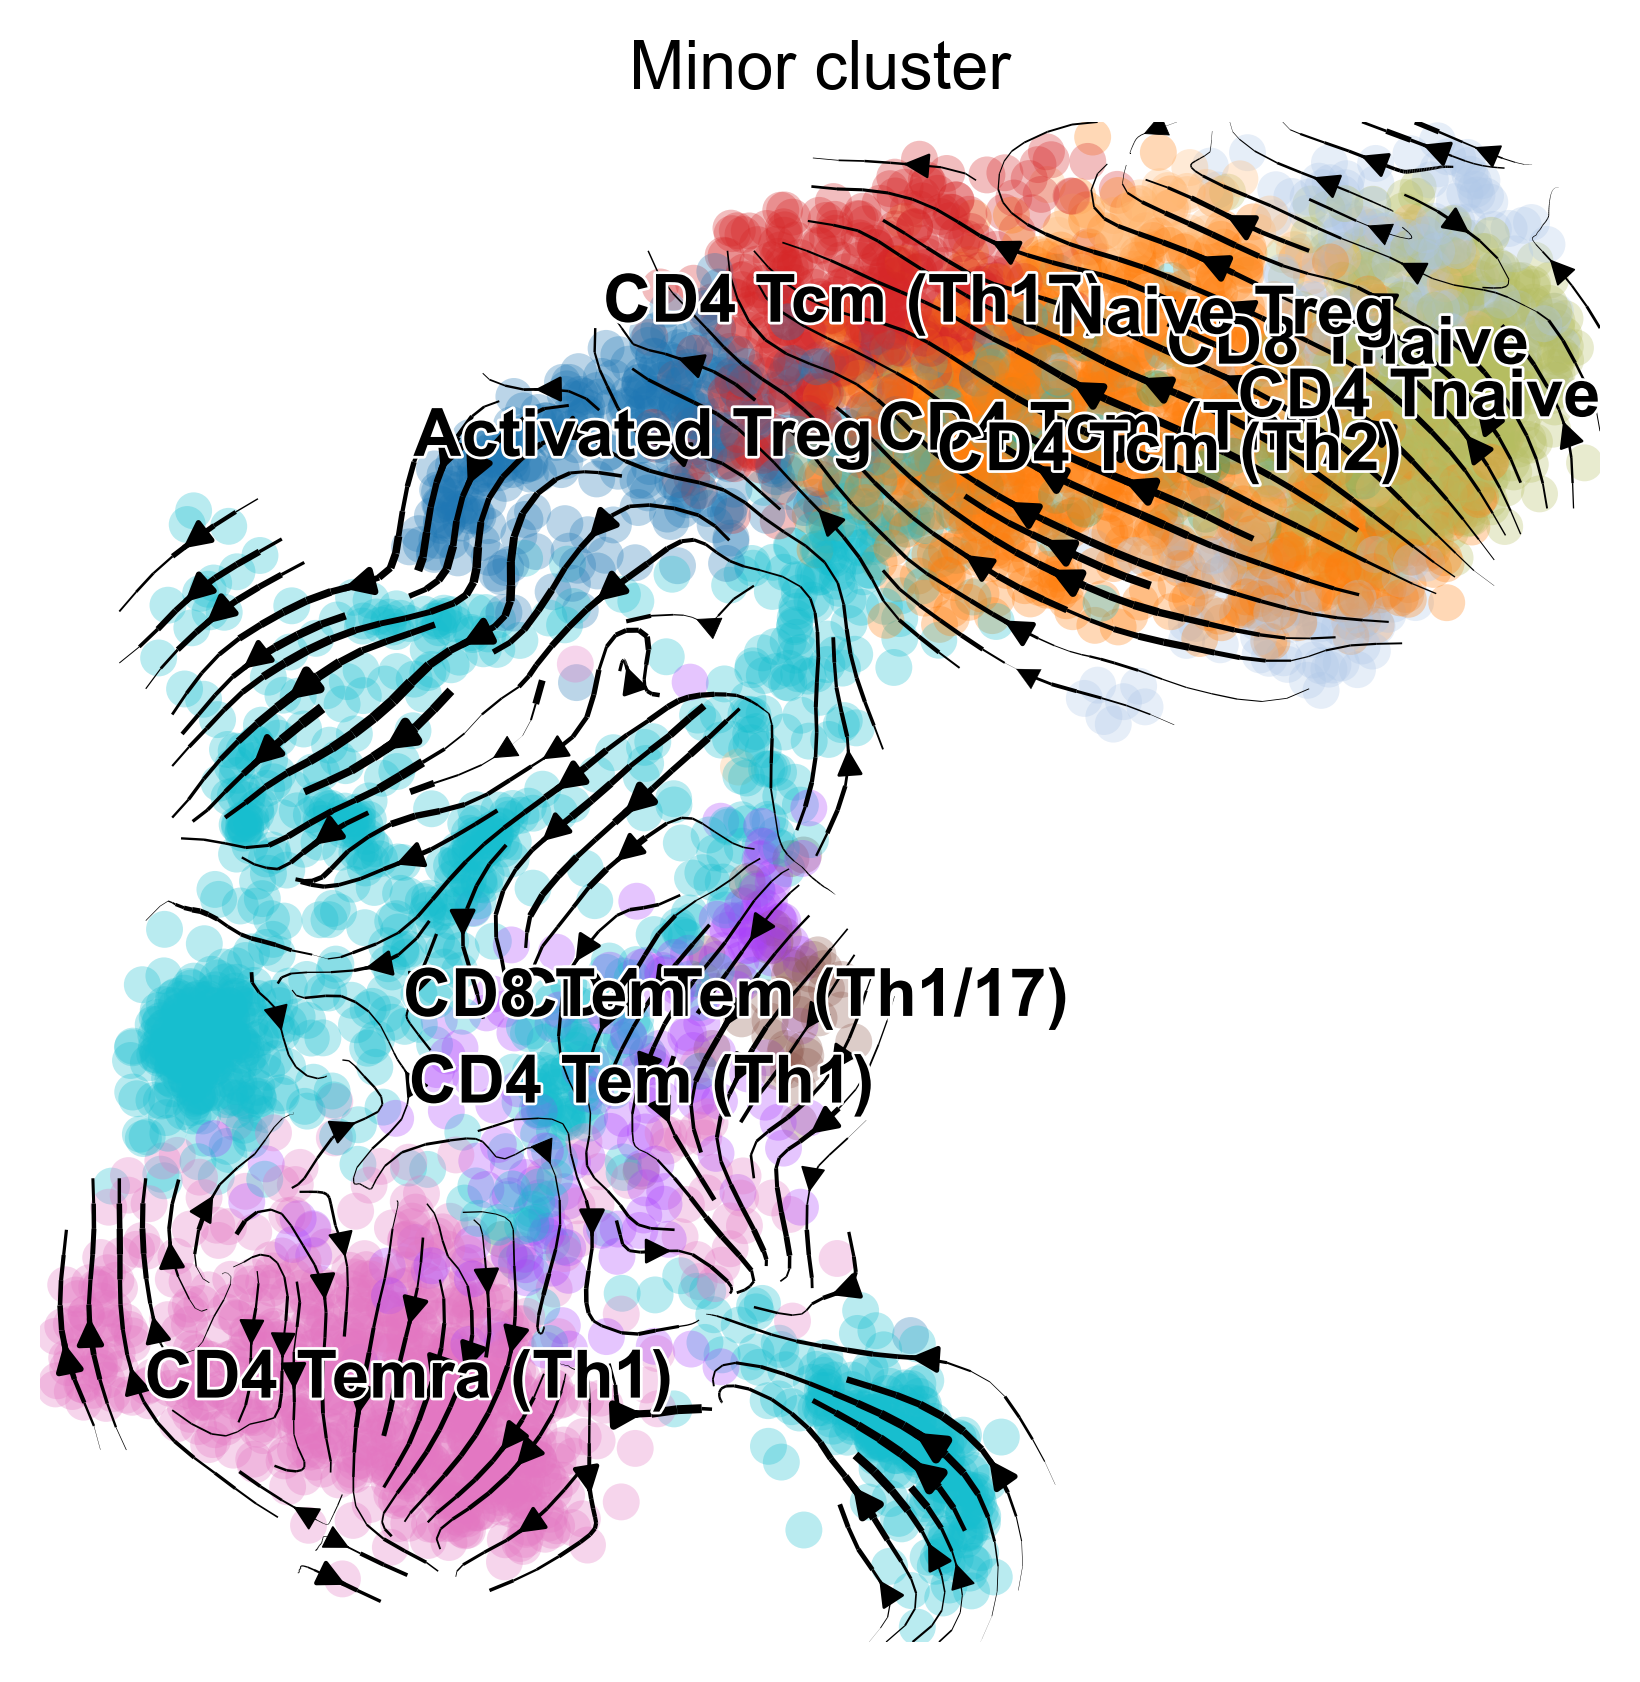

In [14]:
scv.pp.neighbors(adata_MC_T_MC)
scv.pp.moments(adata_MC_T_MC, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata_MC_T_MC, n_jobs=10)
scv.tl.velocity(adata_MC_T_MC, mode='dynamical', n_jobs=10)
scv.tl.velocity_graph(adata_MC_T_MC, n_jobs=10)
scv.set_figure_params(dpi=200, figsize=[5,5], color_map='viridis') #
scv.pl.velocity_embedding_stream(adata_MC_T_MC, basis='umap', figsize=(5,5), save= './figs/scvelo_T.pdf', color='Minor_cluster', color_map='viridis')

figure cannot be saved as pdf, using png instead.
saving figure to file ./figs/scvelo_T.png


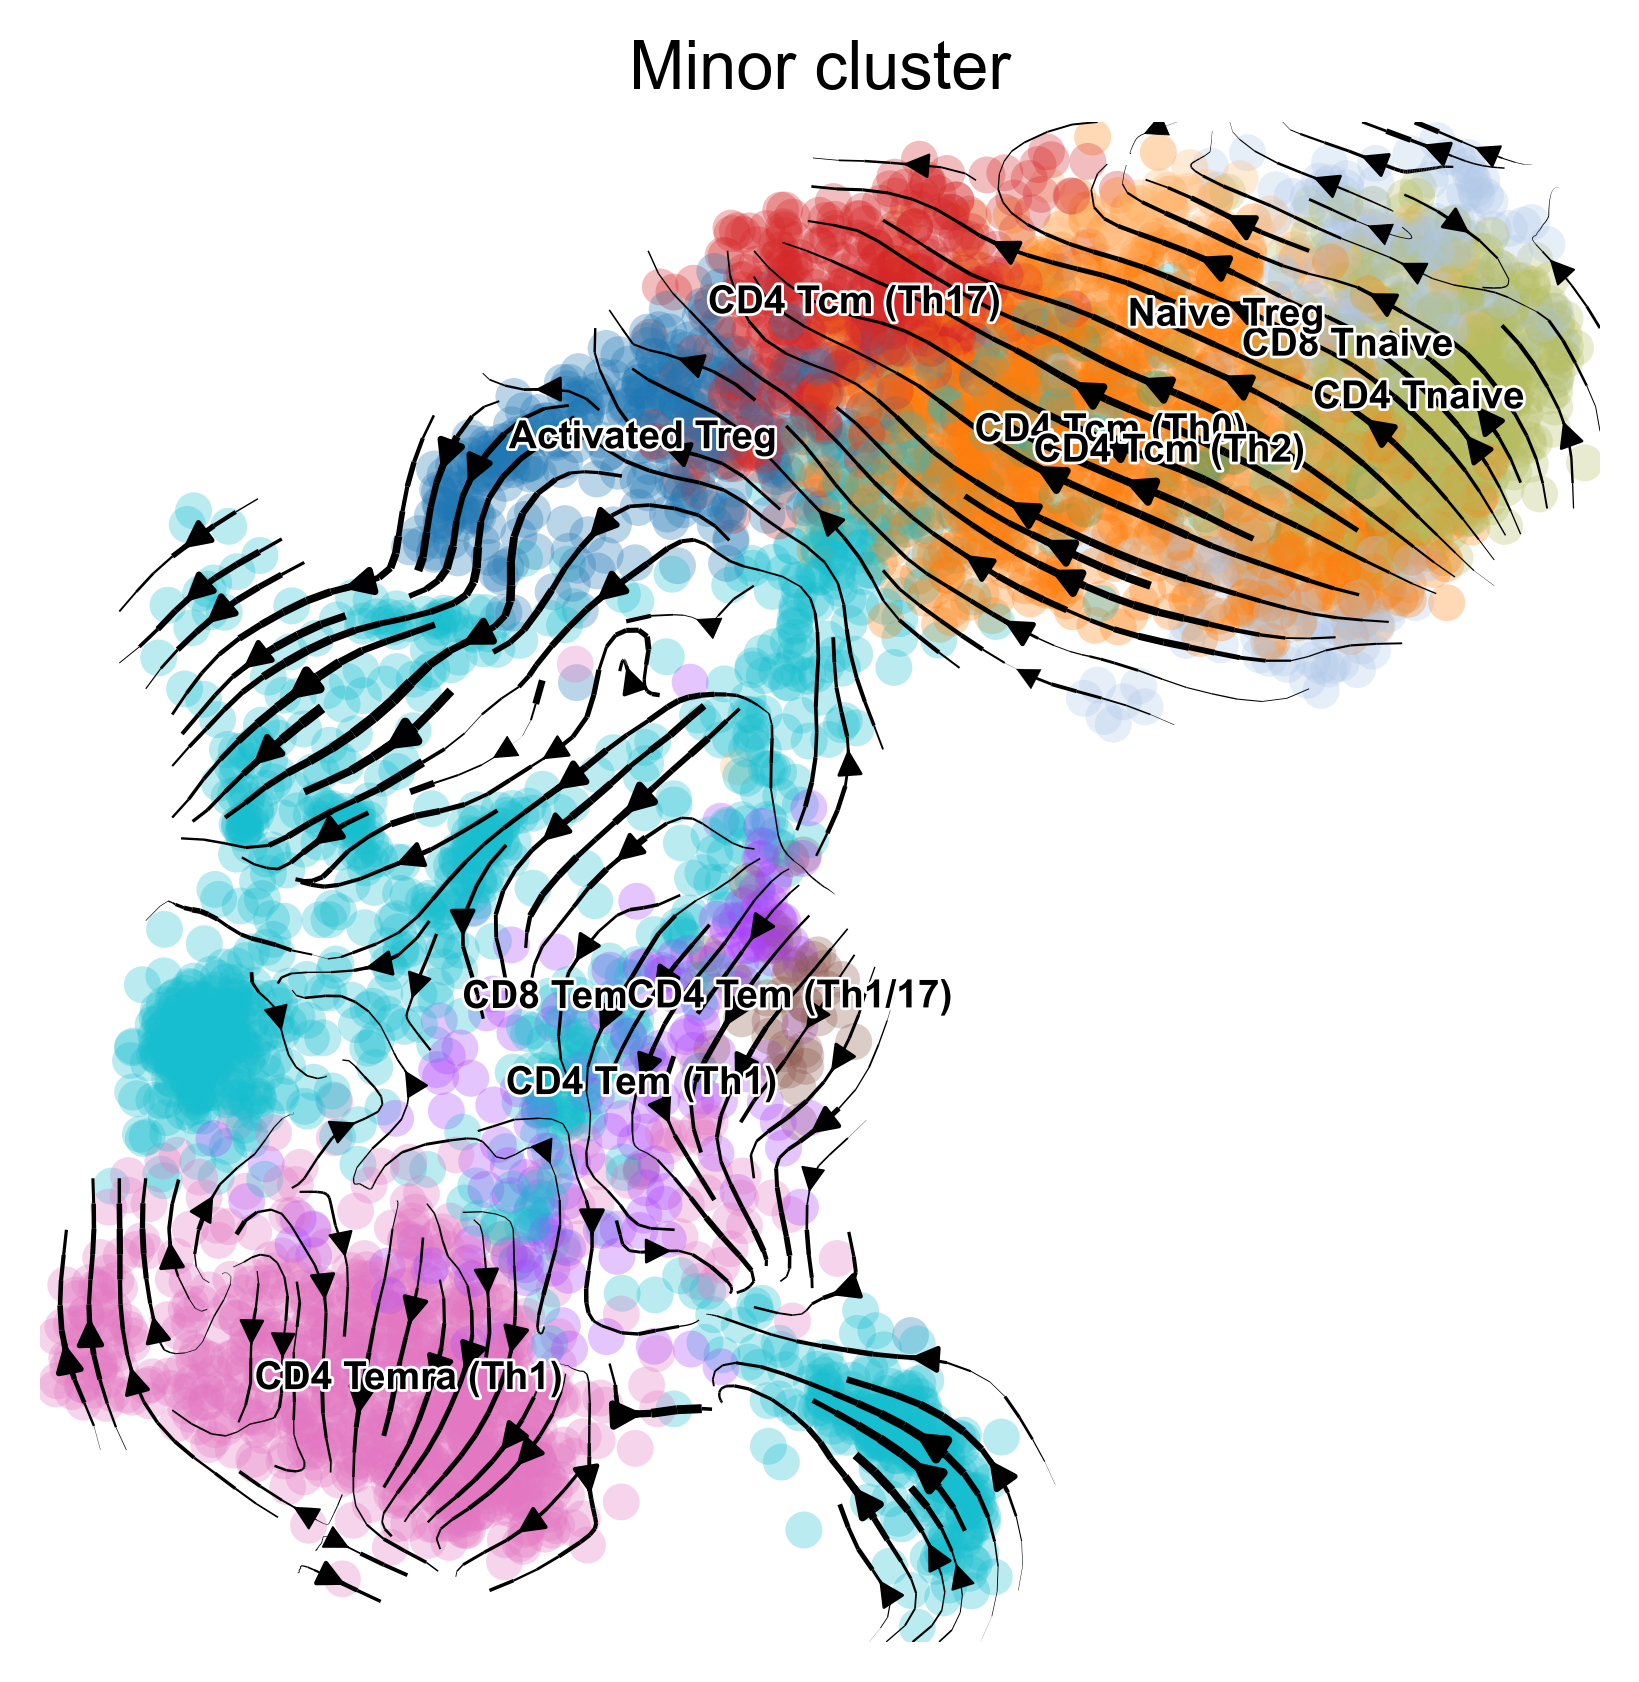

In [15]:
scv.pl.velocity_embedding_stream(adata_MC_T_MC, basis='umap', figsize=(5,5), save= './figs/scvelo_T.pdf', color='Minor_cluster', color_map='viridis', legend_fontsize =7)

# T DEG

In [8]:
sc.tl.rank_genes_groups(adata_MC_T, 'Phenotype', method='wilcoxon', key_added = "wilcoxon")
Crisis_genes = sc.get.rank_genes_groups_df(adata_MC_T, group='MG_crisis', key='wilcoxon')
Crisis_genes = Crisis_genes[(Crisis_genes.pvals_adj < 0.05) & (abs(Crisis_genes.logfoldchanges) > 0.5)].sort_values(by=['logfoldchanges'], ascending=False).reset_index(drop=True)

Crisis_genes_up = Crisis_genes[(Crisis_genes.pvals_adj < 0.05) & (Crisis_genes.logfoldchanges > 0.5)].sort_values(by=['scores'], ascending=False).reset_index(drop=True)
Crisis_genes_down = Crisis_genes[(Crisis_genes.pvals_adj < 0.05) & (Crisis_genes.logfoldchanges < -0.5)].sort_values(by=['scores'], ascending=False).reset_index(drop=True)

glist_up = Crisis_genes_up['names'].squeeze().str.strip().tolist()
glist_down = Crisis_genes_down['names'].squeeze().str.strip().tolist()
glist_all = glist_up + glist_down

print(f'glist_up: {len(glist_up)}, glist_down: {len(glist_down)}, glist_all: {len(glist_all)}')

Crisis_genes.to_csv('./write/T_DEG_MC_vs_AC.csv', index=False)

glist_up: 74, glist_down: 934, glist_all: 1008


['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

<AxesSubplot: title={'center': 'CellMarker_Augmented_2021'}, xlabel='Combined Score'>

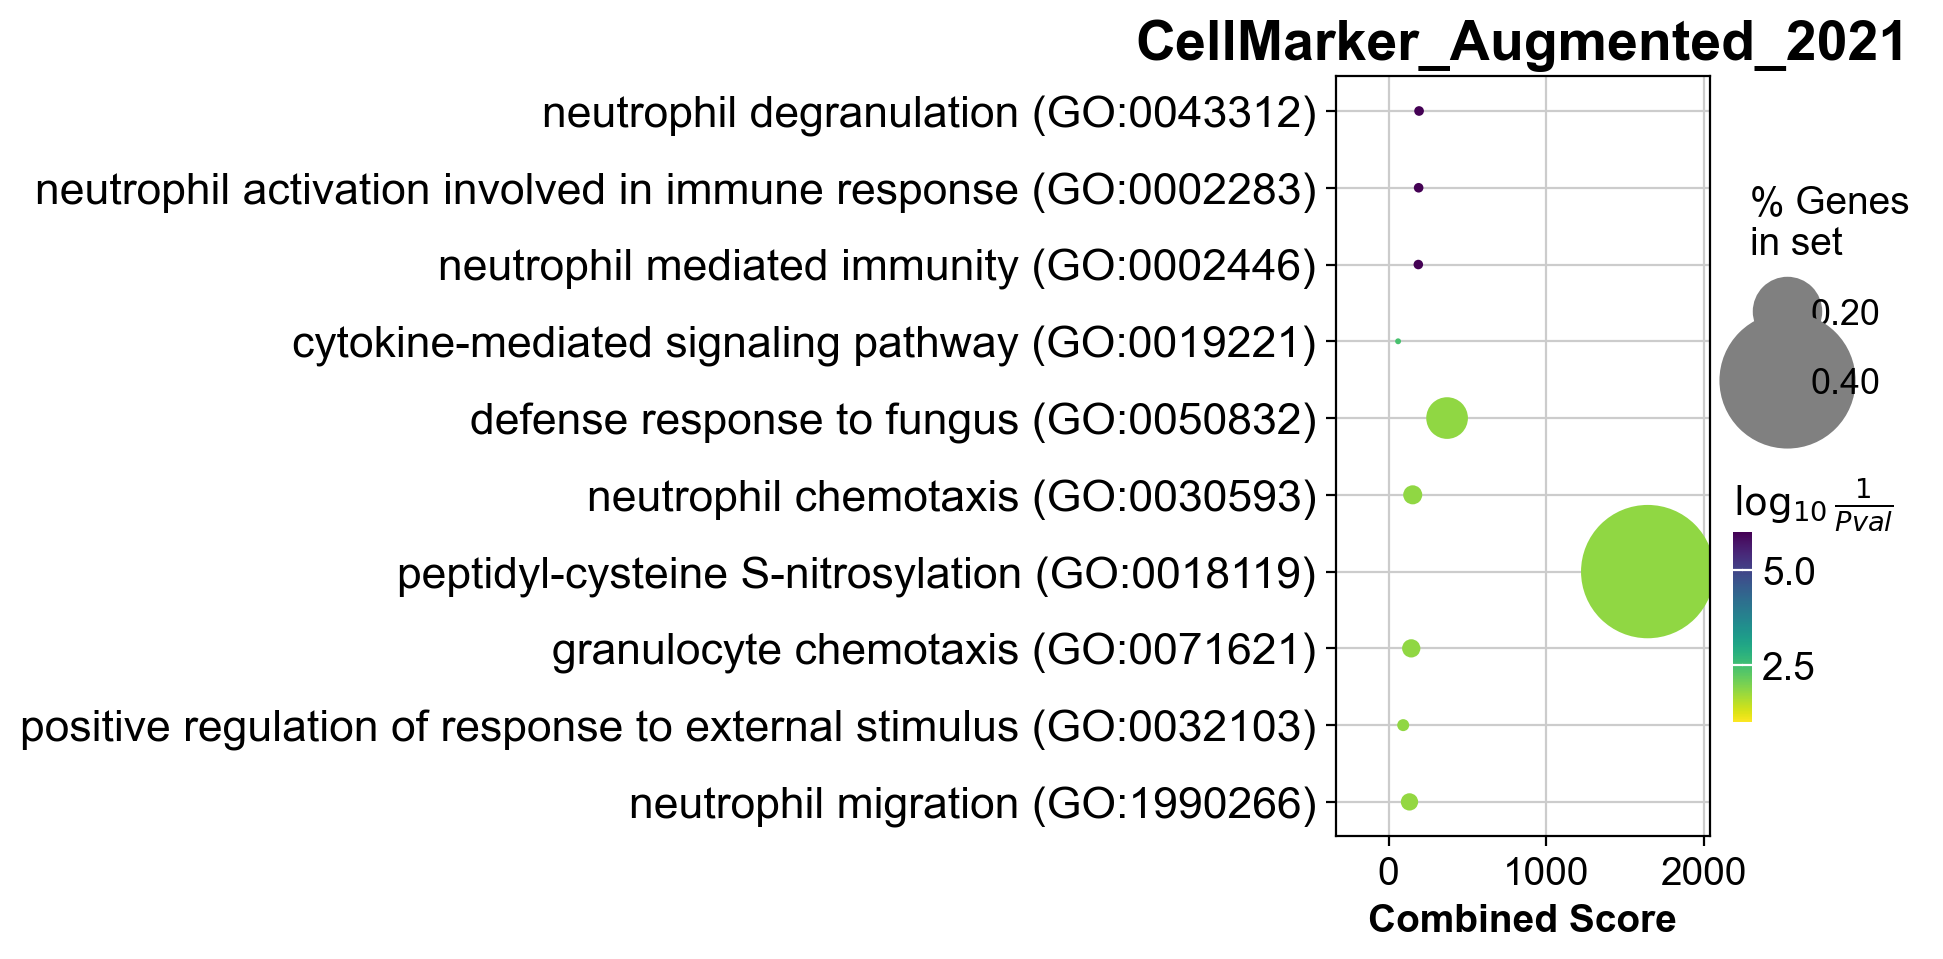

In [17]:
import gseapy as gp

#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gp.get_library_name(organism='Human')
print(gene_set_names)

#GO_Biological_Process_2021, GO_Cellular_Component_2021, GO_Molecular_Function_2021, Human_Phenotype_Ontology, CellMarker_Augmented_2021, KEGG_2021_Human, Reactome_2022, WikiPathway_2021_Human

sc.set_figure_params(dpi=100, color_map = 'viridis_r', transparent=False, frameon=False)


enr_res = gp.enrichr(gene_list=glist_up,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021',
                     top_term= 10,
                     cutoff = 0.5)

#enr_res.results.head(10)

gp.dotplot(enr_res.res2d, title='CellMarker_Augmented_2021',cmap='viridis_r', size=20, figsize=(3,5), cutoff = 0.5)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

<AxesSubplot: title={'center': 'CellMarker_Augmented_2021'}, xlabel='Combined Score'>

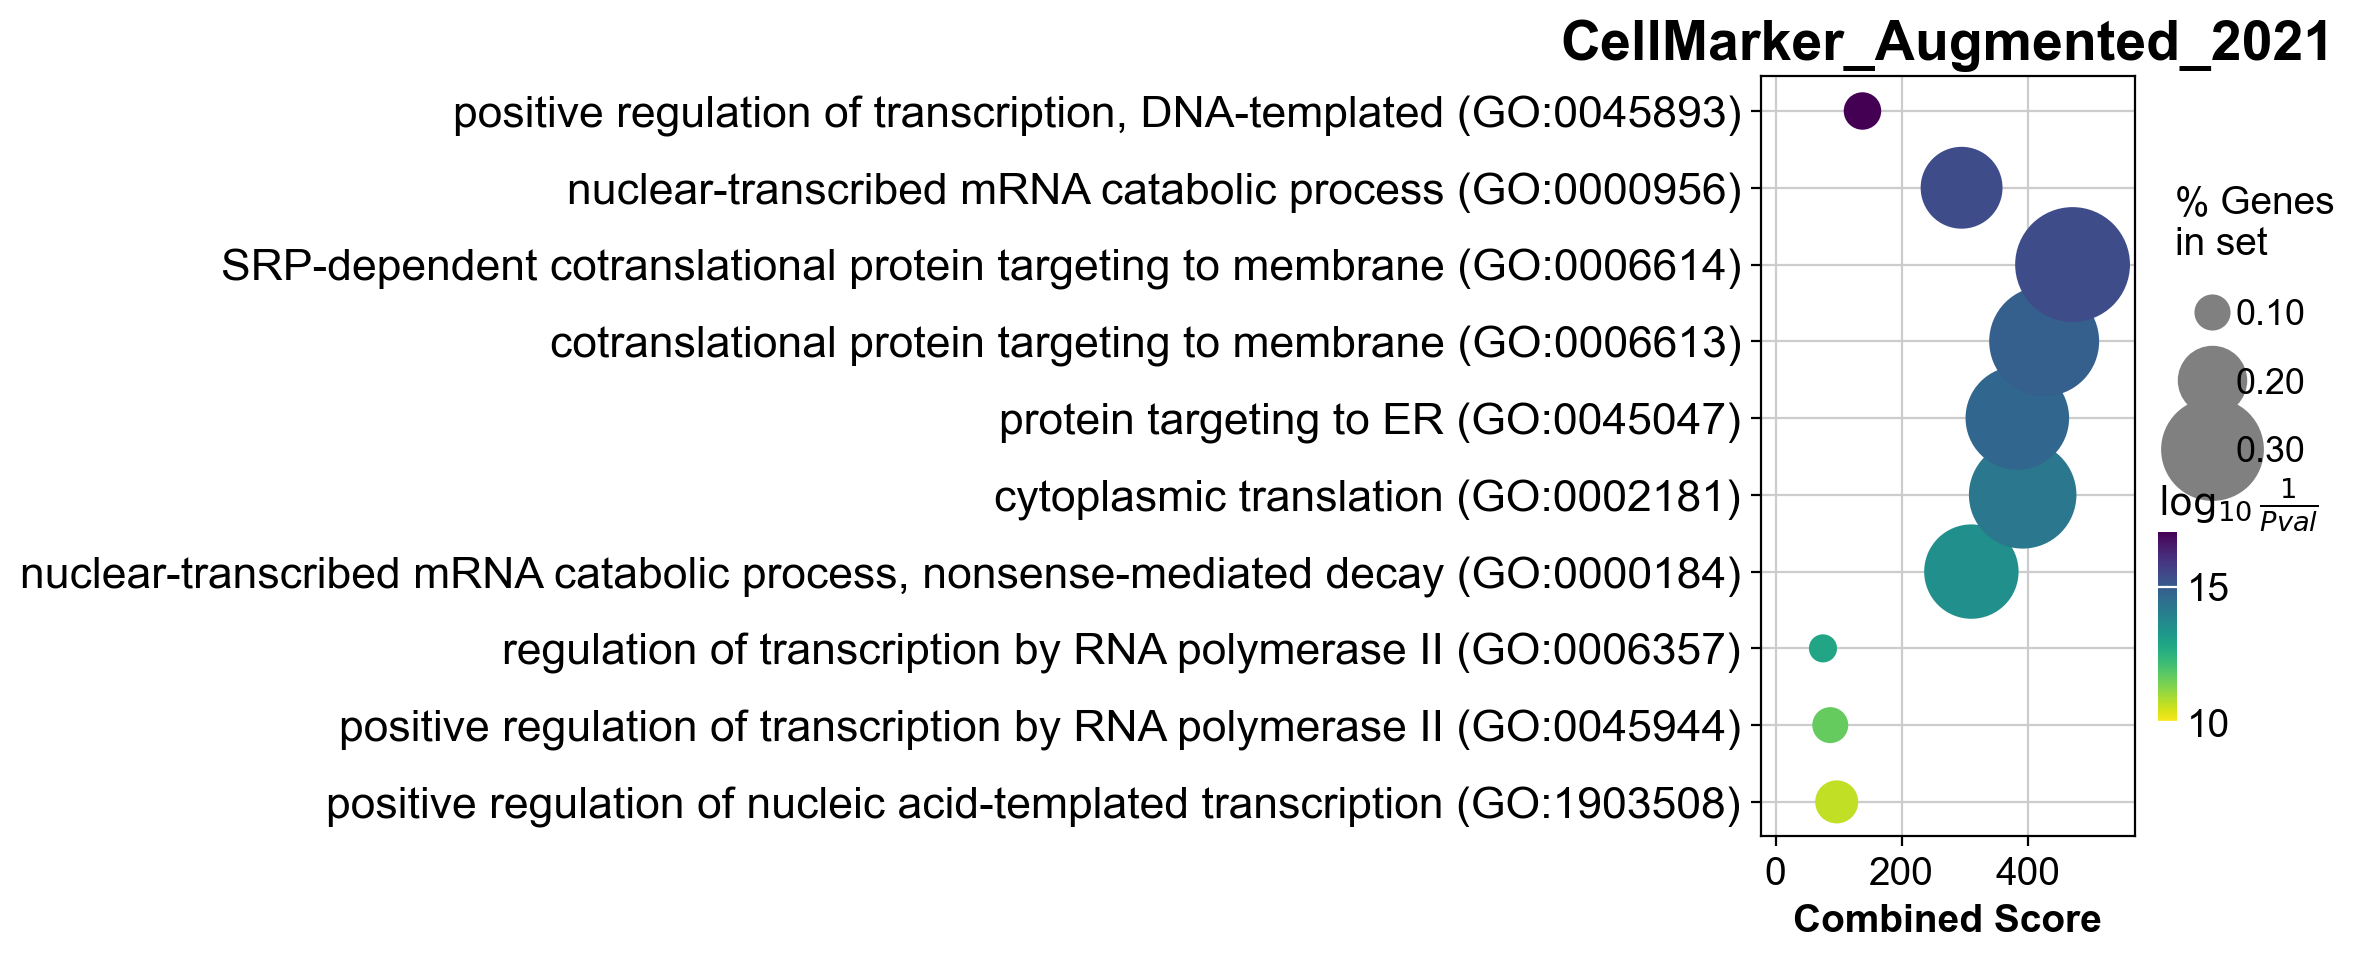

In [18]:
import gseapy as gp

#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gp.get_library_name(organism='Human')
print(gene_set_names)

#GO_Biological_Process_2021, GO_Cellular_Component_2021, GO_Molecular_Function_2021, Human_Phenotype_Ontology, CellMarker_Augmented_2021, KEGG_2021_Human, Reactome_2022, WikiPathway_2021_Human

sc.set_figure_params(dpi=100, color_map = 'viridis_r', transparent=False, frameon=False)


enr_res = gp.enrichr(gene_list=glist_down,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021',
                     top_term= 10,
                     cutoff = 0.5)

#enr_res.results.head(10)

gp.dotplot(enr_res.res2d, title='CellMarker_Augmented_2021',cmap='viridis_r', size=20, figsize=(3,5), cutoff = 0.5)

# T-related pathway scores

In [16]:
# T_exhaustion_score
T_exhaustion_set = ['PDCD1', 'CTLA4', 'HAVCR2', 'LAG3', 'TIGIT']

# T_activation_score
T_activation_set = ['HLA-DRA', 'HLA-DRB1', 'CD38']

sc.tl.score_genes(adata_MC_T, T_exhaustion_set, score_name = 'T_exhaustion_score')
sc.tl.score_genes(adata_MC_T, T_activation_set, score_name = 'T_activation_score')

adata_MC_T.obs

initial_size_spliced  initial_size_unspliced  \
AAACCTGAGTGTGAAT-0                   157                     243   
AAACCTGGTTGTACAC-0                   164                     474   
AAACCTGTCAGCGATT-0                   188                     313   
AAACCTGTCCAATGGT-0                   431                     517   
AAACCTGTCCCAAGTA-0                   190                     311   
...                                  ...                     ...   
TTTGTCAAGAAGATTC-3                   187                     300   
TTTGTCAAGGTGGGTT-3                   304                     396   
TTTGTCACAAGAAGAG-3                   223                     334   
TTTGTCAGTTATCCGA-3                   314                     486   
TTTGTCATCAACACTG-3                   278                     554   

                    initial_size     Phenotype   donor_id batch  n_genes  \
AAACCTGAGTGTGAAT-0         157.0     MG_crisis  Patient_1     0     1190   
AAACCTGGTTGTACAC-0         164.0     MG_crisis  Patient_1     0     1920   
AAACCTGTCAGCGATT-0         188.0     MG_crisis  Patient_1     0     1449   
AAACCTGTCCAATGGT-0         431.0     MG_crisis  Patient_1     0     1989   
AAACCTGTCCCAAGTA-0         190.0     MG_crisis  Patient_1     0     1362   
...                          ...           ...        ...   ...      ...   
TTTGTCAAGAAGATTC-3         187.0  After_crisis  Patient_2     3     1332   
TTTGTCAAGGTGGGTT-3         304.0  After_crisis  Patient_2     3     1602   
TTTGTCACAAGAAGAG-3         223.0  After_crisis  Patient_2     3     1625   
TTTGTCAGTTATCCGA-3         314.0  After_crisis  Patient_2     3     1616   
TTTGTCATCAACACTG-3         278.0  After_crisis  Patient_2     3     1384   

                    n_genes_by_counts  total_counts  total_counts_mt  ...  \
AAACCTGAGTGTGAAT-0               1190        2688.0             54.0  ...   
AAACCTGGTTGTACAC-0               1920        3196.0             57.0  ...   
AAACCTGTCAGCGATT-0               1449        2864.0             38.0  ...   
AAACCTGTCCAATGGT-0               1989        4437.0             54.0  ...   
AAACCTGTCCCAAGTA-0               1362        3384.0             49.0  ...   
...                               ...           ...              ...  ...   
TTTGTCAAGAAGATTC-3               1332        3393.0             33.0  ...   
TTTGTCAAGGTGGGTT-3               1602        4690.0             56.0  ...   
TTTGTCACAAGAAGAG-3               1624        4337.0             56.0  ...   
TTTGTCAGTTATCCGA-3               1616        5154.0              9.0  ...   
TTTGTCATCAACACTG-3               1384        3398.0            103.0  ...   

                        majority_voting_builtin leiden Major_cluster  \
AAACCTGAGTGTGAAT-0                   MAIT cells      2       T cells   
AAACCTGGTTGTACAC-0  Tem/Temra cytotoxic T cells     13       T cells   
AAACCTGTCAGCGATT-0  Tem/Temra cytotoxic T cells      2       T cells   
AAACCTGTCCAATGGT-0  Tem/Temra cytotoxic T cells     13       T cells   
AAACCTGTCCCAAGTA-0     Tcm/Naive helper T cells      1       T cells   
...                                         ...    ...           ...   
TTTGTCAAGAAGATTC-3     Tcm/Naive helper T cells      1       T cells   
TTTGTCAAGGTGGGTT-3    Tem/Trm cytotoxic T cells      1       T cells   
TTTGTCACAAGAAGAG-3           Regulatory T cells      1       T cells   
TTTGTCAGTTATCCGA-3     Tcm/Naive helper T cells      1       T cells   
TTTGTCATCAACACTG-3  Tem/Effector helper T cells      1       T cells   

                                    Sample    Minor_cluster Major_category  \
AAACCTGAGTGTGAAT-0     Patient_1_MG_crisis          CD8 Tem              T   
AAACCTGGTTGTACAC-0     Patient_1_MG_crisis          CD8 Tem              T   
AAACCTGTCAGCGATT-0     Patient_1_MG_crisis  CD4 Temra (Th1)              T   
AAACCTGTCCAATGGT-0     Patient_1_MG_crisis          CD8 Tem              T   
AAACCTGTCCCAAGTA-0     Patient_1_MG_crisis    CD4 Tcm (Th0)              T   
...                             

In [18]:
scores = [ 'T_exhaustion_score', 'T_activation_score']
df = sc.get.obs_df(adata_MC_T, scores + ['Minor_cluster','Phenotype', 'donor_id'], use_raw=False)
df2 = df.melt(id_vars=["Minor_cluster",'Phenotype', 'donor_id'], value_vars=scores)


Minor_cluster_order = ['CD4 Tnaive', 'CD4 Tcm (Th0)', 'CD4 Tcm (Th2)', 'CD4 Tcm (Th17)', 'CD4 Tem (Th1)', 'CD4 Tem (Th1/17)', 'CD4 Temra (Th1)', 'CD8 Tnaive', 'CD8 Tem', 'Naive Treg', 'Activated Treg']
Phenotype_order = ['MG_crisis', 'After_crisis']

df2["Minor_cluster"] = df2["Minor_cluster"].cat.set_categories(Minor_cluster_order, ordered=True)
df2["Phenotype"] = df2["Phenotype"].cat.set_categories(Phenotype_order, ordered=True)

df2

Minor_cluster     Phenotype   donor_id            variable     value
0              CD8 Tem     MG_crisis  Patient_1  T_exhaustion_score  0.235583
1              CD8 Tem     MG_crisis  Patient_1  T_exhaustion_score -0.177916
2      CD4 Temra (Th1)     MG_crisis  Patient_1  T_exhaustion_score -0.171233
3              CD8 Tem     MG_crisis  Patient_1  T_exhaustion_score  0.113150
4        CD4 Tcm (Th0)     MG_crisis  Patient_1  T_exhaustion_score -0.090594
...                ...           ...        ...                 ...       ...
19209    CD4 Tcm (Th0)  After_crisis  Patient_2  T_activation_score -0.655766
19210          CD8 Tem  After_crisis  Patient_2  T_activation_score -0.631550
19211   Activated Treg  After_crisis  Patient_2  T_activation_score -0.256972
19212    CD4 Tcm (Th0)  After_crisis  Patient_2  T_activation_score -0.562685
19213          CD8 Tem  After_crisis  Patient_2  T_activation_score -0.566652

[19214 rows x 5 columns]

meta NOT subset; don't know how to subset; dropped


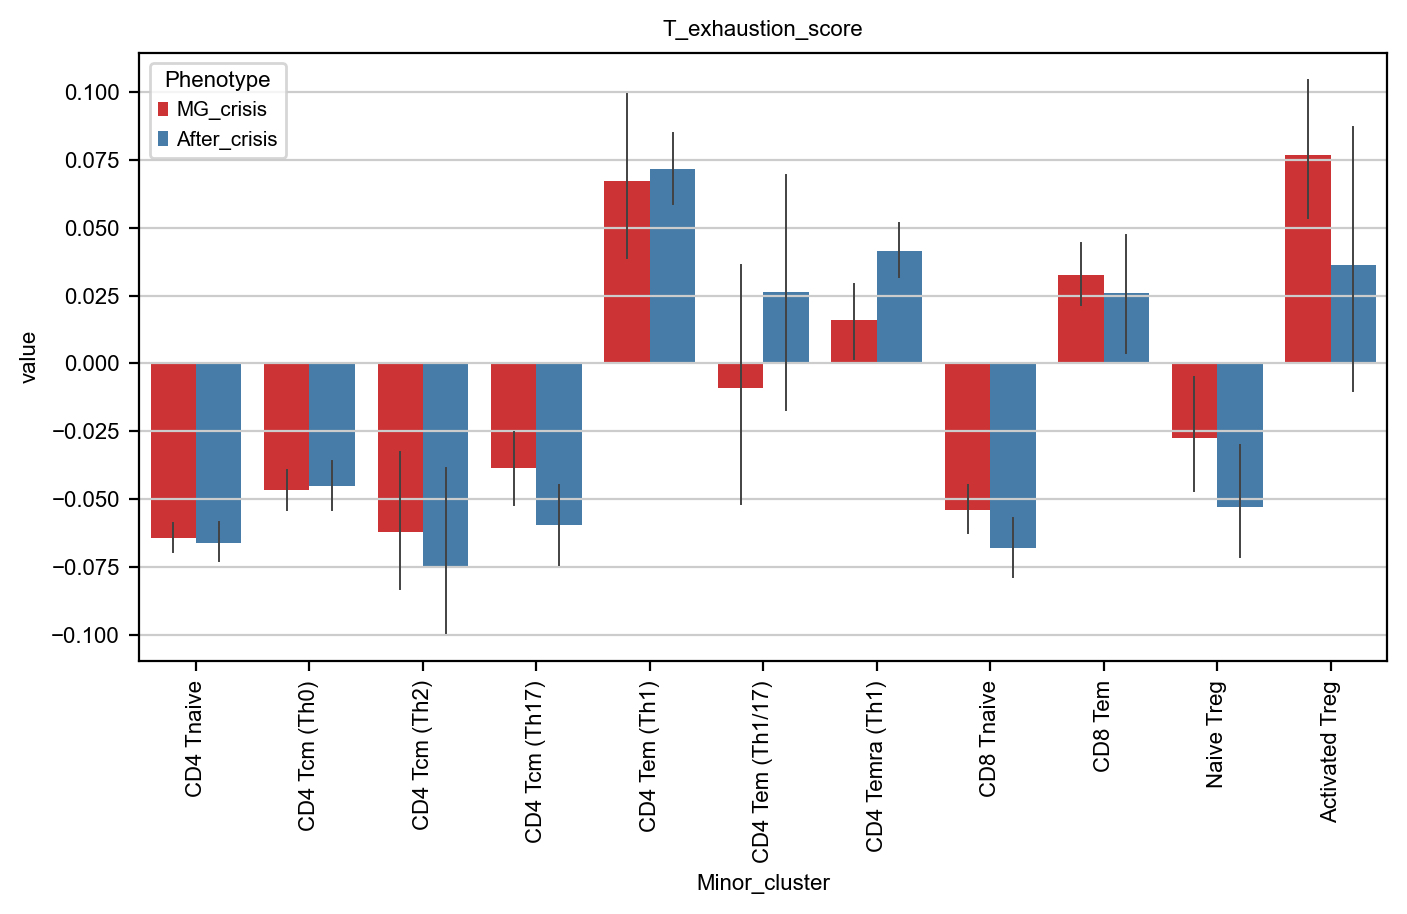

In [19]:
sc.set_figure_params(dpi=100, color_map = 'Set1', transparent=True, frameon=False, fontsize=8, figsize= [8, 4])

#sns.barplot(data=df2[(df2['variable'] == 'SRSF1') & (df2['Donor'] == 'patient_3') ], x="Minor_cluster", y="value", hue="Phenotype", errwidth=0.7)
sns.barplot(data=df2[(df2['variable'] == 'T_exhaustion_score')], x="Minor_cluster", y="value", hue="Phenotype",hue_order= ['MG_crisis', 'After_crisis'], palette="Set1", errwidth=0.7).set(title='T_exhaustion_score')

plt.xticks(rotation=90)
plt.savefig('./figs/T_exhaustion_score.pdf')

meta NOT subset; don't know how to subset; dropped


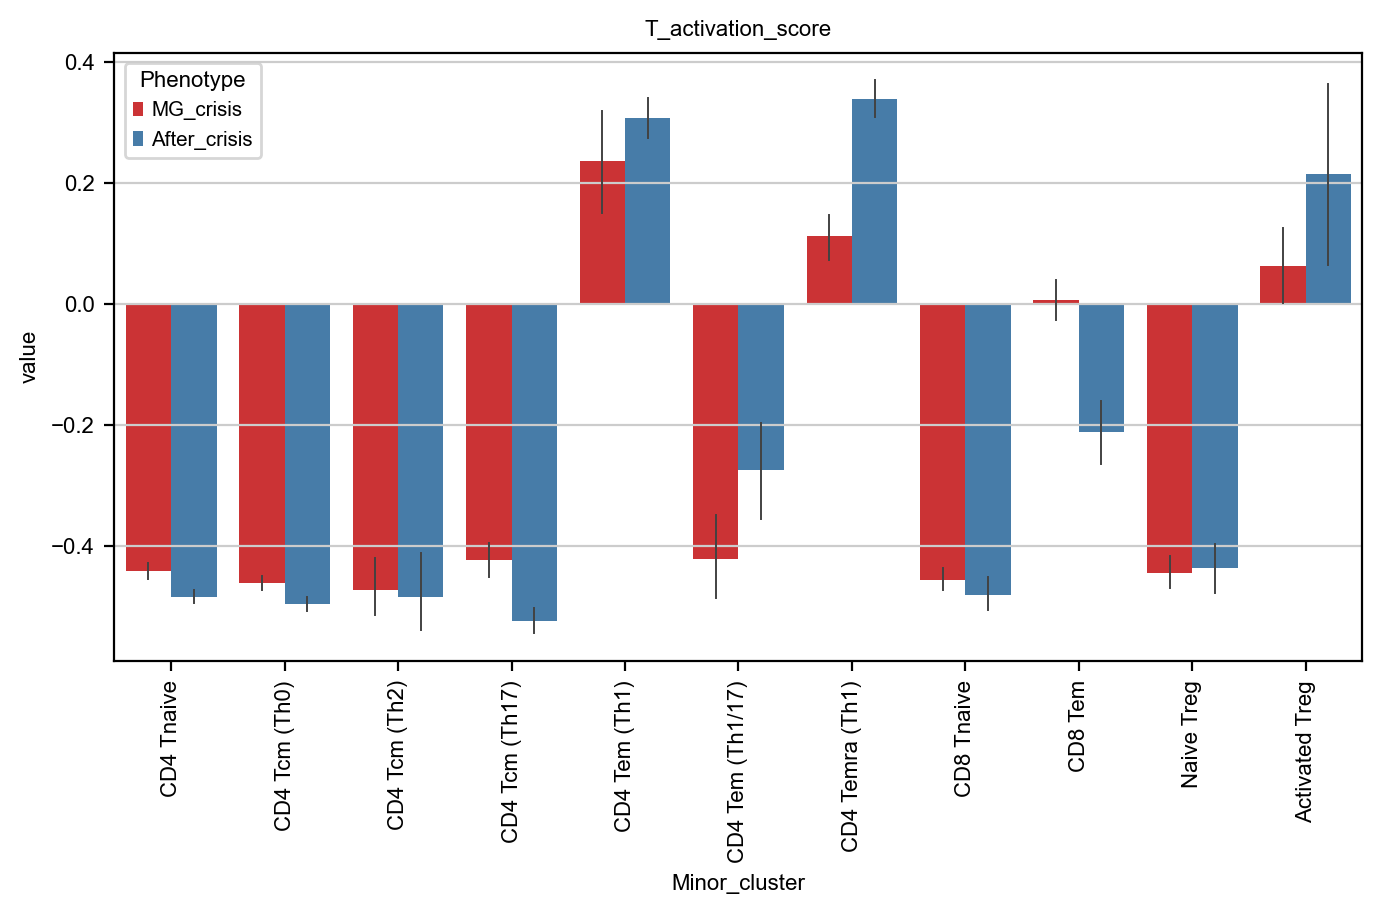

In [20]:
sc.set_figure_params(dpi=100, color_map = 'Set1', transparent=True, frameon=False, fontsize=8, figsize= [8, 4])

#sns.barplot(data=df2[(df2['variable'] == 'SRSF1') & (df2['Donor'] == 'patient_3') ], x="Minor_cluster", y="value", hue="Phenotype", errwidth=0.7)
sns.barplot(data=df2[(df2['variable'] == 'T_activation_score')], x="Minor_cluster", y="value", hue="Phenotype",hue_order= ['MG_crisis', 'After_crisis'], palette="Set1", errwidth=0.7).set(title='T_activation_score')

plt.xticks(rotation=90)
plt.savefig('./figs/T_activation_score.pdf')